# Ejercicio 05

In [14]:
import numpy as np

In [15]:
import matplotlib.pyplot as plt

## Lectura de la imagen original

In [16]:
from skimage.io import imread

In [17]:
from skimage.io import imsave

In [18]:
original_image = imread('../resources/mono.bmp')

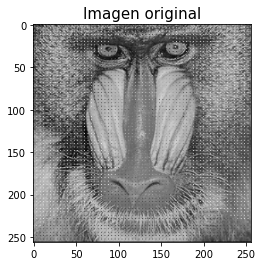

In [70]:
plt.imshow(original_image, cmap='gray')
plt.title('Imagen original', fontsize=15)
plt.show()

In [20]:
print(f'El tamaño original es {original_image.shape}')

El tamaño original es (256, 256)


## Espectro de la imagen original
Se calcula la transformada rápida de fourier en dos dimensiones para la imagen original.

In [161]:
spectrum_original = np.fft.fftshift(np.fft.fft2(original_image, s=(256, 256)))

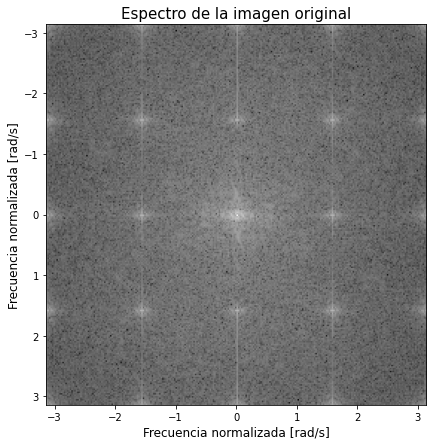

In [162]:
plt.figure(figsize=(15, 7))
plt.imshow(np.log10(np.abs(spectrum_original)), cmap='gray', extent=[-np.pi, np.pi, np.pi, -np.pi])
plt.xlabel('Frecuencia normalizada [rad/s]', fontsize=12)
plt.ylabel('Frecuencia normalizada [rad/s]', fontsize=12)
plt.title('Espectro de la imagen original', fontsize=15)
plt.show()

## Decimación de la imagen
La **decimación** consiste en disminuir la frecuencia de muestreo, es decir, disminuir la cantidad de muestras que en este caso corresponden a píxeles de la imagen. Además, se puede aplicar algún procesamiento particular para determinar cómo generar los píxeles nuevos. En esta sección, se aplicará decimación escogiendo píxeles de posiciones particulares, o encontrando el valor promedio de los píxeles.

In [23]:
from skimage.measure import block_reduce

In [24]:
def extract_position(block: np.array, x: int, y: int):
    """ Returns a specific position from the given pixel block.
        @param block Pixel block of arbitrary shape
        @param x Coordinate for the selected pixel in the pixel block
        @param y Coordinate for the selected pixel in the pixel block
        @return Returns the pixel content
    """
    if x >= block.shape[0] or y >= block.shape[1]:
        raise ValueError('Coordinates out of the block')
    return block[x, y]

def extract_position_from_blocks(blocks: np.array, x: int, y: int) -> np.array:
    """ Receives a numpy array of arbitrary shape containing pixel blocks of a given size
        and extracts a particular position or pixel. Returns the same numpy array of arbitrary
        shape replacing each pixel block with the corresponding extracted pixel.
        @param blocks Numpy array of pixel blocks
        @param x Coordinate for the selected pixel in the pixel block
        @param y Coordinate for the selected pixel in the pixel block
        @return Returns a numpy array
    """
    new_blocks = np.zeros((blocks.shape[0], blocks.shape[1]))
    for i in range(blocks.shape[0]):
        for j in range(blocks.shape[1]):
            new_blocks[i, j] = extract_position(blocks[i, j], x, y)
    return new_blocks

In [97]:
image_a = block_reduce(original_image, block_size=(4, 4), func=lambda blocks, axis: extract_position_from_blocks(blocks, 1, 1))

In [26]:
image_b = block_reduce(original_image, block_size=(4, 4), func=lambda blocks, axis: extract_position_from_blocks(blocks, 0, 0))

In [27]:
image_c = block_reduce(original_image, block_size=(4, 4), func=np.mean)

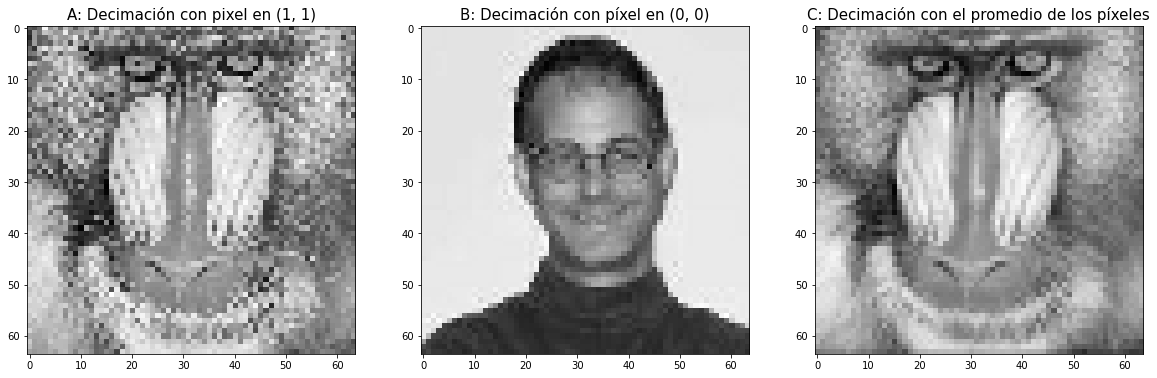

In [82]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(image_a, cmap='gray')
ax[0].set_title('A: Decimación con pixel en (1, 1)', fontsize=15)
ax[1].imshow(image_b, cmap='gray')
ax[1].set_title('B: Decimación con píxel en (0, 0)', fontsize=15)
ax[2].imshow(image_c, cmap='gray')
ax[2].set_title('C: Decimación con el promedio de los píxeles', fontsize=15)
plt.show()

## Interpolación bilineal
La interpolación bilineal consiste en encontrar el valor de los píxeles agregados por el proceso de upsampling en una imagen, utilizando los cuatro píxeles conocidos más cercanos que lo rodean. Los píxeles conocidos se emplean realizando una interpolación lineal en dos pasos, primero en el eje de coordenadas x y luego en el eje de coordenadas y. Para ello, se transforman las coordenadas según se muestra en la siguiente ilustración,

![title](../resources/imagen_ex_05_a.png)

Así, el interpolador se puede pensar como un campo escalar que determina el valor del píxel de acuerdo a la ubicación a interpolar, según se muestra en la siguiente expresión,

$$f(x,y)=f(0,0) \cdot (1-x) \cdot (1-y) + f(1,0) \cdot x \cdot (1-y) + f(0,1) \cdot (1-x) \cdot y + f(1,1) \cdot x \cdot y$$

Escrito matricialmente, se obtiene que,

$$f(x,y) = X \cdot F \cdot Y = \begin{pmatrix} 1-x & x \end{pmatrix} \cdot \begin{pmatrix} f(0,0) & f(0,1) \\ f(1,0) &  f(1,1) \end{pmatrix} \cdot \begin{pmatrix} 1-y \\ y \end{pmatrix} $$

In [102]:
def bilinear_interpolator(image, ratio):
    """ Upsamples an image applying the bilinear interpolation.
        @param image Original image
        @param ratio Upsampling factor
        @return Interpolated image
    """
    # Fetch the original shape and create the new shape
    input_x, input_y = image.shape
    output_x = int(input_x * ratio)
    output_y = int(input_y * ratio)
    # Create the new image with zeros
    output_image = np.zeros((output_x, output_y))
    for i in range(output_x):
        for j in range(output_y):
            # Coordinates measured from the original image
            aux_x = i / ratio
            aux_y = j / ratio
            # Search for the 4 points used for the interpolation
            x1 = int(aux_x)
            y1 = int(aux_y)
            x2 = x1
            y2 = y1 + 1
            x3 = x1 + 1
            y3 = y1
            x4 = x1 + 1
            y4 = y1 + 1
            x = aux_x - int(aux_x)
            y = aux_y - int(aux_y)
            # When the iteration is already in the limit of the image
            if x4 >= input_x:
                x4 = input_x - 1
                x3 = x4
                x2 = x4 - 1
                x1 = x2
            if y4 >= input_y:
                y4 = input_y - 1
                y3 = y4
                y2 = y4 - 1
                y1 = y2
            # Formula for bilinear interpolation
            X = np.array([[1-x, x]])
            F = np.array([[image[x1, y1], image[x2, y2]], [image[x3, y3], image[x4, y4]]])
            Y = np.array([[1-y, y]]).T
            output_image[i, j] = X @ F @ Y
    return output_image

In [104]:
image_a_bilinear = bilinear_interpolator(image_a, 4)

In [105]:
image_b_bilinear = bilinear_interpolator(image_b, 4)

In [106]:
image_c_bilinear = bilinear_interpolator(image_c, 4)

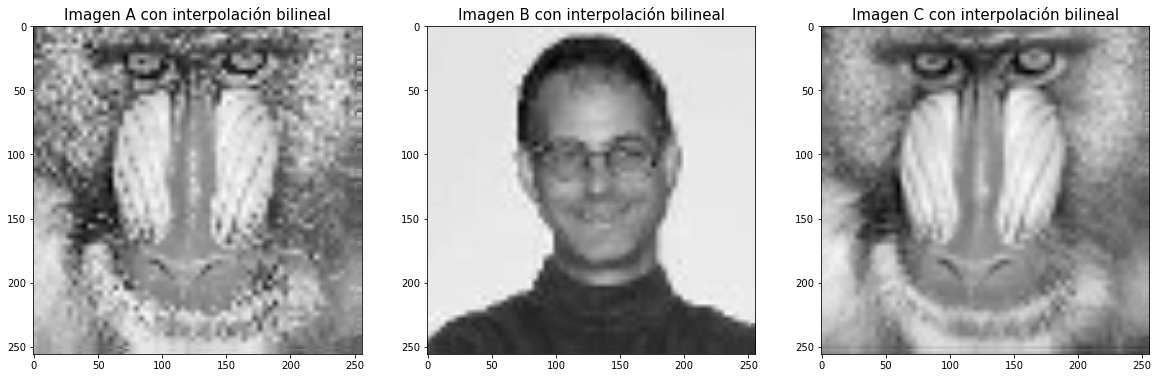

In [107]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(image_a_bilinear, cmap='gray')
ax[0].set_title('Imagen A con interpolación bilineal', fontsize=15)
ax[1].imshow(image_b_bilinear, cmap='gray')
ax[1].set_title('Imagen B con interpolación bilineal', fontsize=15)
ax[2].imshow(image_c_bilinear, cmap='gray')
ax[2].set_title('Imagen C con interpolación bilineal', fontsize=15)
plt.show()

## Espectro de interpolaciones bilineales
Se calcula la transformada rápida de fourier para las imágenes resultantes de la interpolación bilineal.

In [108]:
spectrum_bilinear_a = np.fft.fftshift(np.fft.fft2(image_a_bilinear, s=(256, 256)))

In [109]:
spectrum_bilinear_b = np.fft.fftshift(np.fft.fft2(image_b_bilinear, s=(256, 256)))

In [110]:
spectrum_bilinear_c = np.fft.fftshift(np.fft.fft2(image_c_bilinear, s=(256, 256)))

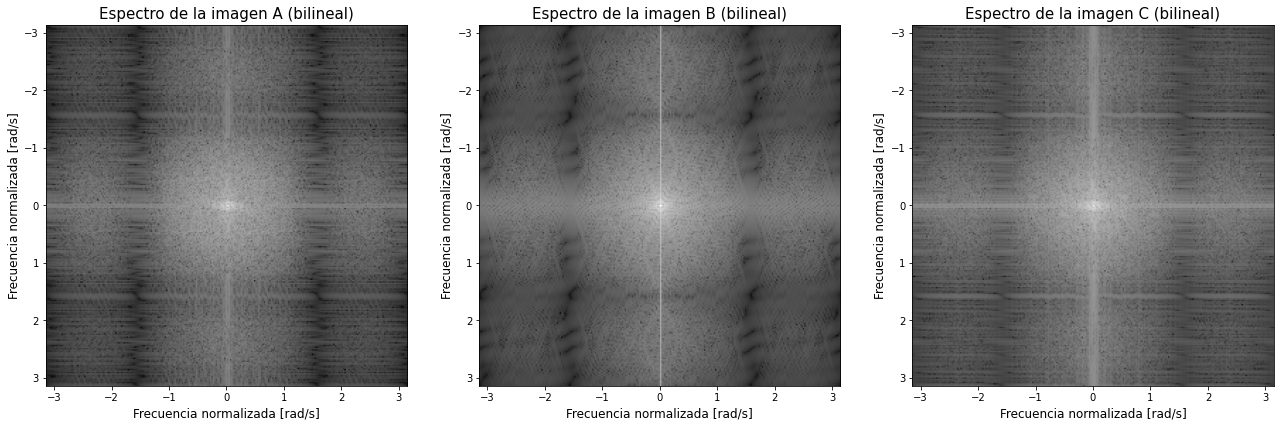

In [148]:
fig, ax = plt.subplots(1, 3, figsize=(22, 15))
ax[0].set_title('Espectro de la imagen A (bilineal)', fontsize=15)
ax[0].imshow(np.log10(np.abs(spectrum_bilinear_a)), cmap='gray', extent=[-np.pi, np.pi, np.pi, -np.pi])
ax[0].set_xlabel('Frecuencia normalizada [rad/s]', fontsize=12)
ax[0].set_ylabel('Frecuencia normalizada [rad/s]', fontsize=12)
ax[1].set_title('Espectro de la imagen B (bilineal)', fontsize=15)
ax[1].imshow(np.log10(np.abs(spectrum_bilinear_b)), cmap='gray', extent=[-np.pi, np.pi, np.pi, -np.pi])
ax[1].set_xlabel('Frecuencia normalizada [rad/s]', fontsize=12)
ax[1].set_ylabel('Frecuencia normalizada [rad/s]', fontsize=12)
ax[2].set_title('Espectro de la imagen C (bilineal)', fontsize=15)
ax[2].imshow(np.log10(np.abs(spectrum_bilinear_c)), cmap='gray', extent=[-np.pi, np.pi, np.pi, -np.pi])
ax[2].set_xlabel('Frecuencia normalizada [rad/s]', fontsize=12)
ax[2].set_ylabel('Frecuencia normalizada [rad/s]', fontsize=12)
plt.show()

## Interpolación bicúbica

¡Agregar explicación aquí!

In [125]:
def bicubic_interpolator(image, ratio):
    """ Upsamples an image applying the bicubic interpolation.
        @param image Original image
        @param ratio Upsampling factor
        @return Interpolated image
    """
    # Code here...

In [126]:
image_a_bicubic = bicubic_interpolator(image_a, 4)

In [127]:
image_b_bicubic = bicubic_interpolator(image_b, 4)

In [128]:
image_c_bicubic = bicubic_interpolator(image_c, 4)

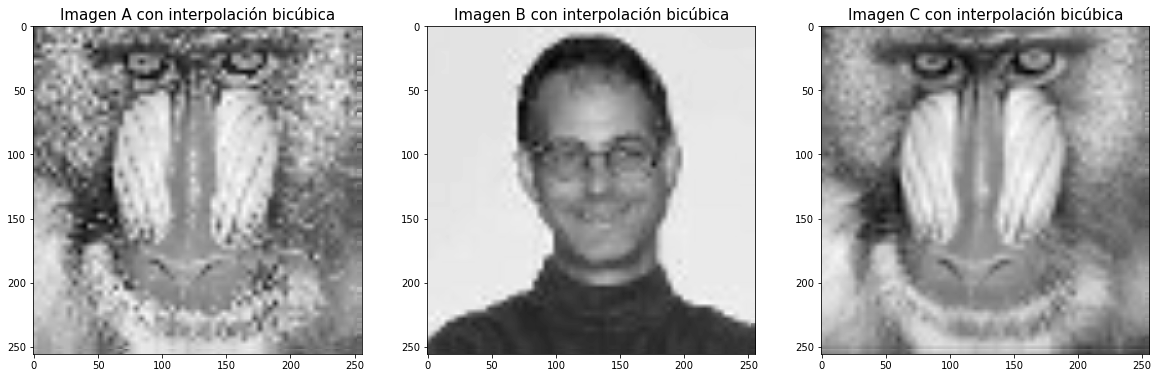

In [129]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(image_a_bicubic, cmap='gray')
ax[0].set_title('Imagen A con interpolación bicúbica', fontsize=15)
ax[1].imshow(image_b_bicubic, cmap='gray')
ax[1].set_title('Imagen B con interpolación bicúbica', fontsize=15)
ax[2].imshow(image_c_bicubic, cmap='gray')
ax[2].set_title('Imagen C con interpolación bicúbica', fontsize=15)
plt.show()

## Espectro de interpolaciones bicúbicas
Se calcula la transformada rápida de fourier para las imágenes resultantes de la interpolación bicúbica.

In [130]:
spectrum_bicubic_a = np.fft.fftshift(np.fft.fft2(image_a_bicubic, s=(256, 256)))

In [131]:
spectrum_bicubic_b = np.fft.fftshift(np.fft.fft2(image_b_bicubic, s=(256, 256)))

In [132]:
spectrum_bicubic_c = np.fft.fftshift(np.fft.fft2(image_c_bicubic, s=(256, 256)))

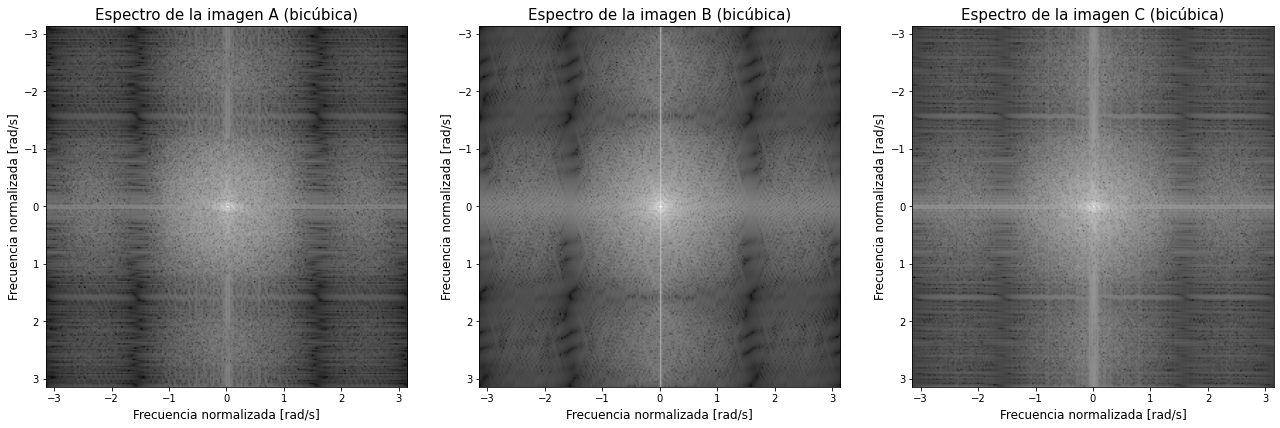

In [149]:
fig, ax = plt.subplots(1, 3, figsize=(22, 15))
ax[0].set_title('Espectro de la imagen A (bicúbica)', fontsize=15)
ax[0].imshow(np.log10(np.abs(spectrum_bicubic_a)), cmap='gray', extent=[-np.pi, np.pi, np.pi, -np.pi])
ax[0].set_xlabel('Frecuencia normalizada [rad/s]', fontsize=12)
ax[0].set_ylabel('Frecuencia normalizada [rad/s]', fontsize=12)
ax[1].set_title('Espectro de la imagen B (bicúbica)', fontsize=15)
ax[1].imshow(np.log10(np.abs(spectrum_bicubic_b)), cmap='gray', extent=[-np.pi, np.pi, np.pi, -np.pi])
ax[1].set_xlabel('Frecuencia normalizada [rad/s]', fontsize=12)
ax[1].set_ylabel('Frecuencia normalizada [rad/s]', fontsize=12)
ax[2].set_title('Espectro de la imagen C (bicúbica)', fontsize=15)
ax[2].imshow(np.log10(np.abs(spectrum_bicubic_c)), cmap='gray', extent=[-np.pi, np.pi, np.pi, -np.pi])
ax[2].set_xlabel('Frecuencia normalizada [rad/s]', fontsize=12)
ax[2].set_ylabel('Frecuencia normalizada [rad/s]', fontsize=12)
plt.show()